# QSVM vs SVM — Protocolo Reproducible con Validación Cruzada, Tuning, Repeticiones y Significancia

*Generado automáticamente: 2025-10-27T02:53:43*

Este cuaderno implementa un **protocolo robusto** para comparar **QSVM** (kernel cuántico) vs **SVM** (kernels clásicos) con:
- Validación cruzada estratificada (k-fold) con **repeticiones** por *seeds*.
- **Búsqueda de hiperparámetros** (GridSearch/ParameterGrid) comparable entre modelos.
- **Pruebas de significancia** (t pareada y Wilcoxon) y **tamaños de efecto**.
- **Alineación de kernels** (clásicos vs cuántico) para justificar la elección del kernel.
- Exportación de resultados y *artefactos* (CSV/JSON) para auditoría.


## 0) Requisitos e instalación (ejecutar una vez)

> **Nota:** Este cuaderno no se ejecuta aquí. Ejecútalo localmente con un entorno que tenga Qiskit y Qiskit Machine Learning instalados (ver *pip* abajo).


In [ ]:
# Recomendado (ajusta versiones según tu entorno):
# !pip install --upgrade pip
# !pip install qiskit==1.4.4 qiskit-machine-learning==0.8.4 scikit-learn==1.4.2 scipy pandas matplotlib
# Opcional: IBM Runtime (si usarás hardware real)
# !pip install qiskit-ibm-runtime==0.23.0


## 1) Configuración y reproducibilidad
- Semillas globales
- Control de *backend* cuántico (simulador vs IBM Runtime)
- Carpeta de salida para resultados


In [11]:
import os, json, math, random, pathlib, time, itertools, statistics, functools
from dataclasses import dataclass
from pathlib import Path
import numpy as np
import pandas as pd

# Reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Salidas
OUT_DIR = Path("results_qsvm_experiment")
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("Seed:", SEED)
print("Output dir:", OUT_DIR.resolve())


Seed: 42
Output dir: C:\Users\Cassandra\Desktop\qsvm_cristian\results_qsvm_experiment


## 2) Datos y *pipeline* base
- Dataset: **Breast Cancer Wisconsin** (scikit-learn)
- **Estandarización** + (opcional) **PCA**
- Separación estratificada se maneja dentro de la CV


In [12]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

data = load_breast_cancer()
X = data.data
y = data.target
feature_names = data.feature_names

print("X shape:", X.shape, "| y shape:", y.shape, "| classes:", set(y))


X shape: (569, 30) | y shape: (569,) | classes: {np.int64(0), np.int64(1)}


In [13]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import StatevectorSampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_aer import AerSimulator

def preprocess_features(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    backend = AerSimulator()
    try:
        #max_qubits = backend.configuration().num_qubits
        max_qubits = 10
    except Exception:
        max_qubits = 29

    n_features = X_scaled.shape[1]
    if n_features > max_qubits:
        print(f"[INFO] El dataset tiene {n_features} features, reduciendo a {max_qubits} mediante PCA.")
        pca = PCA(n_components=max_qubits, random_state=42)
        X_reduced = pca.fit_transform(X_scaled)
        return X_reduced, pca
    else:
        print(f"[INFO] El dataset tiene {n_features} features, no se aplica PCA.")
        return X_scaled, None


In [14]:

# === Paso adicional: preprocesamiento automático (PCA si excede qubits) ===
X, pca_model = preprocess_features(X)

[INFO] El dataset tiene 30 features, reduciendo a 10 mediante PCA.


## 3) Protocolo de validación
- **RepeatedStratifiedKFold** para obtener múltiples *splits* con distintas semillas.
- Parametrizable: `n_splits` y `n_repeats`.


In [15]:
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, GridSearchCV

N_SPLITS = 2
N_REPEATS = 2  # ajusta si deseas más/menos repeticiones

rskf = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=SEED)
print(f"Protocol: {N_SPLITS}-fold CV x {N_REPEATS} repeats -> {N_SPLITS*N_REPEATS} evaluations")


Protocol: 2-fold CV x 2 repeats -> 4 evaluations


## 4) Modelos clásicos — SVM con tuning comparable
- *Pipeline*: `StandardScaler` → `SVC`
- *Grid search* de `C` y `gamma` para RBF; además añadimos **kernels lineal y polinomial** para la discusión.
- Métrica principal: **accuracy** (puedes añadir F1 macro).


In [16]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, make_scorer

svm_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(probability=True, random_state=SEED))
])

# Buscaremos sobre múltiples kernels; para lineal y poly, gamma se ignora automáticamente
param_grid_svm = [
    {"svc__kernel": ["rbf"], "svc__C": [0.1, 1, 10, 100], "svc__gamma": ["scale", 0.01, 0.1, 1]},
    {"svc__kernel": ["linear"], "svc__C": [0.1, 1, 10, 100]},
    {"svc__kernel": ["poly"], "svc__C": [0.1, 1, 10], "svc__degree": [2, 3], "svc__gamma": ["scale", 0.1]}
]

scorer = make_scorer(accuracy_score)  # principal; puedes añadir f1_macro en otro GridSearch
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

svm_gs = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=param_grid_svm,
    scoring=scorer,
    cv=inner_cv,
    n_jobs=-1,
    refit=True,
    verbose=1
)


## 5) QSVM — Kernel cuántico con tuning y CV equiparable
- *Feature map* (por defecto **ZZFeatureMap**) con `reps` como hiperparámetro.
- **FidelityQuantumKernel** (simulador por defecto; IBM Runtime opcional).
- Usamos **QSVC** de Qiskit Machine Learning (interfaz estilo scikit-learn).
- Dado que `GridSearchCV` puede ser restrictivo con estimadores personalizados, **iteramos manualmente una `ParameterGrid`** y aplicamos la misma CV externa (`rskf`) para cada configuración.


In [17]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import FidelityQuantumKernel
#from qiskit_algorithms.kernels import QuantumKernel
from qiskit_machine_learning.algorithms import QSVC
from qiskit_aer import AerSimulator
from qiskit.primitives import Sampler, StatevectorSampler, BackendSampler
from qiskit_algorithms.state_fidelities import ComputeUncompute

#import warnings
#warnings.filterwarnings("ignore", category=DeprecationWarning)


# Kernel cuántico usando SOLO simulador local (sin IBM Runtime)
def make_quantum_kernel(reps=2, feature_dimension=None):
    if feature_dimension is None:
        raise ValueError("Debes indicar feature_dimension = número de columnas del dataset")

    feature_map = ZZFeatureMap(feature_dimension=feature_dimension, reps=reps, entanglement="linear")
    sampler = StatevectorSampler()
    fidelity = ComputeUncompute(sampler=sampler)
    qk = FidelityQuantumKernel(feature_map=feature_map, fidelity=fidelity)
    return qk


# Espacio de hiperparámetros QSVM (tuning comparable)
from sklearn.model_selection import ParameterGrid
param_grid_qsvm = {
    "reps": [1, 2, 3],     # profundidad del feature map
    "C": [0.1, 1, 10]      # parámetro de margen del clasificador SVM subyacente
}
grid_qsvm = list(ParameterGrid(param_grid_qsvm))
print("QSVM grid size:", len(grid_qsvm))



QSVM grid size: 9


# Espacio con hardware IBM

In [ ]:
# IMPORTS QSVM (se asume entorno con Qiskit ML)
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC
from qiskit_ibm_runtime import QiskitRuntimeService, Session

# Backend selector (simulador por defecto)
USE_IBM_RUNTIME = False  # cambia a True si tienes IBM Runtime configurado
IBM_CHANNEL = None       # 'ibm_quantum' o 'ibm_cloud'; requiere autenticación previa

# Definición de kernel cuántico (simulador por defecto)
def make_quantum_kernel(reps=2, feature_dimension=None):

    service = QiskitRuntimeService(channel="ibm_cloud", token="McQGbuC5M-k3vyOLJWIZ2vI1T7goLOs90GRXreYivLHH", instance="ibm_escuela")
    #service = QiskitRuntimeService.save_account(channel="ibm_cloud", token="hRGgo7sQETDfg6nSrpFUfDOQNHzQLOTCz3D7TaDOvjEL")
    backend = service.backend("ibm_brisbane")

    #with Session(service=service, backend=backend):
    fm = ZZFeatureMap(feature_dimension=feature_dimension, reps=reps, entanglement="full")
    qk = FidelityQuantumKernel(feature_map=fm,)  # usa simulador de estado por defecto
    return qk

# Espacio de hiperparámetros QSVM (tuning comparable)
from sklearn.model_selection import ParameterGrid
param_grid_qsvm = {
    "reps": [1, 2, 3],     # profundidad del feature map
    "C": [0.1, 1, 10]      # parámetro de margen del clasificador SVM subyacente
}
grid_qsvm = list(ParameterGrid(param_grid_qsvm))
print("QSVM grid size:", len(grid_qsvm))


QSVM grid size: 9


## 6) Bucle de evaluación — Métricas por *split* para SVM y QSVM
- Para cada *split* de `RepeatedStratifiedKFold`:
  - Hacemos *GridSearch* para SVM clásico (inner-CV).
  - Iteramos `ParameterGrid` para QSVM y guardamos la mejor combinación.
- Guardamos métricas por *split* para **análisis estadístico** posterior.


In [18]:
from collections import defaultdict

from sklearn.metrics import accuracy_score, f1_score

def evaluate_on_split(X_train, y_train, X_test, y_test, seed=SEED):
    # --- SVM clásico con GridSearchCV ---
    svm_gs.fit(X_train, y_train)
    best_svm = svm_gs.best_estimator_
    y_pred_svm = best_svm.predict(X_test)
    acc_svm = accuracy_score(y_test, y_pred_svm)
    f1_svm = f1_score(y_test, y_pred_svm, average="binary")

    # --- QSVM: iteramos parámetro 'reps' y 'C' ---
    best_qsvm_model = None
    best_qsvm_score = -np.inf
    best_qsvm_params = None

    for params in grid_qsvm:
        qk = make_quantum_kernel(reps=params["reps"], feature_dimension=X_train.shape[1])
        qsvc = QSVC(quantum_kernel=qk, C=params["C"]) 
        qsvc.fit(X_train, y_train)
        y_pred_q = qsvc.predict(X_test)
        acc_q = accuracy_score(y_test, y_pred_q)
        if acc_q > best_qsvm_score:
            best_qsvm_score = acc_q
            best_qsvm_model = qsvc
            best_qsvm_params = params

    # Recalcula f1 para el mejor QSVM
    y_pred_q_best = best_qsvm_model.predict(X_test)
    f1_q = f1_score(y_test, y_pred_q_best, average="binary")

    return {
        "svm": {
            "acc": acc_svm,
            "f1": f1_svm,
            "best_params": svm_gs.best_params_
        },
        "qsvm": {
            "acc": best_qsvm_score,
            "f1": f1_q,
            "best_params": best_qsvm_params
        }
    }

results = []
split_idx = 0
for train_idx, test_idx in rskf.split(X, y):
    split_idx += 1
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    res = evaluate_on_split(X_train, y_train, X_test, y_test, seed=SEED)
    res["split"] = split_idx
    results.append(res)
    print(f"Done split {split_idx}: acc_svm={res['svm']['acc']:.4f} | acc_qsvm={res['qsvm']['acc']:.4f}")

# Exportar resultados crudos
with open(OUT_DIR / "raw_results.json", "w") as f:
    json.dump(results, f, indent=2)
print("Saved raw results ->", OUT_DIR / "raw_results.json")


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Done split 1: acc_svm=0.9509 | acc_qsvm=0.6281
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Done split 2: acc_svm=0.9683 | acc_qsvm=0.6268
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Done split 3: acc_svm=0.9684 | acc_qsvm=0.6281
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Done split 4: acc_svm=0.9472 | acc_qsvm=0.6268
Saved raw results -> results_qsvm_experiment\raw_results.json


## 7) Estadística inferencial y tamaños de efecto
- Comparación **pareada** de *accuracy* (y F1) entre SVM y QSVM por *split*.
- Pruebas: **t-test pareado** y **Wilcoxon**.
- Tamaño de efecto: **Cohen's d** para muestras pareadas.


In [19]:
from scipy import stats
import numpy as np

# Aplanar resultados
acc_svm = [r["svm"]["acc"] for r in results]
acc_qsvm = [r["qsvm"]["acc"] for r in results]
f1_svm  = [r["svm"]["f1"]  for r in results]
f1_qsvm = [r["qsvm"]["f1"] for r in results]

def paired_cohens_d(a, b):
    diff = np.array(a) - np.array(b)
    return diff.mean() / diff.std(ddof=1)

def summary_stats(vec):
    return {"mean": float(np.mean(vec)), "std": float(np.std(vec, ddof=1)), "n": len(vec)}

t_acc = stats.ttest_rel(acc_svm, acc_qsvm)
w_acc = stats.wilcoxon(acc_svm, acc_qsvm)
t_f1  = stats.ttest_rel(f1_svm, f1_qsvm)
w_f1  = stats.wilcoxon(f1_svm, f1_qsvm)

stats_summary = {
    "acc": {
        "svm": summary_stats(acc_svm),
        "qsvm": summary_stats(acc_qsvm),
        "t_paired": {"statistic": float(t_acc.statistic), "pvalue": float(t_acc.pvalue)},
        "wilcoxon": {"statistic": float(w_acc.statistic), "pvalue": float(w_acc.pvalue)},
        "cohens_d": float(paired_cohens_d(acc_svm, acc_qsvm))
    },
    "f1": {
        "svm": summary_stats(f1_svm),
        "qsvm": summary_stats(f1_qsvm),
        "t_paired": {"statistic": float(t_f1.statistic), "pvalue": float(t_f1.pvalue)},
        "wilcoxon": {"statistic": float(w_f1.statistic), "pvalue": float(w_f1.pvalue)},
        "cohens_d": float(paired_cohens_d(f1_svm, f1_qsvm))
    }
}

with open(OUT_DIR / "stats_summary.json", "w") as f:
    json.dump(stats_summary, f, indent=2)
stats_summary


{'acc': {'svm': {'mean': 0.9586978008401286,
   'std': 0.011264746861840041,
   'n': 4},
  'qsvm': {'mean': 0.6274153694094391, 'std': 0.000756104874401973, 'n': 4},
  't_paired': {'statistic': 59.07168177606642,
   'pvalue': 1.0687715126351754e-05},
  'wilcoxon': {'statistic': 0.0, 'pvalue': 0.125},
  'cohens_d': 29.53584088803321},
 'f1': {'svm': {'mean': 0.9674917664819409,
   'std': 0.008973719766731735,
   'n': 4},
  'qsvm': {'mean': 0.7710572473503507, 'std': 0.0005709726128349514, 'n': 4},
  't_paired': {'statistic': 43.980242933539756,
   'pvalue': 2.5875584361510744e-05},
  'wilcoxon': {'statistic': 0.0, 'pvalue': 0.125},
  'cohens_d': 21.990121466769878}}

## 8) Alineación de kernels (justificación de elección de kernel)
- **Kernel alignment** centrado entre matriz de kernel y etiquetas.
- Comparamos: **RBF**, **lineal**, **polinomial** vs **kernel cuántico**.


In [20]:
from sklearn.metrics.pairwise import rbf_kernel, linear_kernel, polynomial_kernel
import math

def center_kernel(K):
    n = K.shape[0]
    H = np.eye(n) - np.ones((n, n))/n
    return H @ K @ H

def kernel_alignment(K, y):
    # y en {-1, +1}
    y_pm = np.where(y==1, 1, -1).astype(float)
    yyT = np.outer(y_pm, y_pm)
    Kc = center_kernel(K)
    Yc = center_kernel(yyT)
    num = np.sum(Kc * Yc)
    den = math.sqrt(np.sum(Kc*Kc) * np.sum(Yc*Yc))
    return float(num/den)

# Submuestreo (opcional) si el kernel cuántico es costoso; aquí usamos todo
X_eval, y_eval = X, y

# Kernels clásicos
K_rbf = rbf_kernel(X_eval, X_eval, gamma=0.1)
K_lin = linear_kernel(X_eval, X_eval)
K_poly = polynomial_kernel(X_eval, X_eval, degree=3)

# Kernel cuántico
qk_eval = make_quantum_kernel(reps=2, feature_dimension=X_eval.shape[1])
K_q = qk_eval.evaluate(X_eval)  # matriz NxN

alignments = {
    "rbf": kernel_alignment(K_rbf, y_eval),
    "linear": kernel_alignment(K_lin, y_eval),
    "poly_d3": kernel_alignment(K_poly, y_eval),
    "quantum_reps2": kernel_alignment(K_q, y_eval)
}

with open(OUT_DIR / "kernel_alignment.json", "w") as f:
    json.dump(alignments, f, indent=2)
alignments


{'rbf': 0.38259177748291556,
 'linear': 0.5675011675456927,
 'poly_d3': 0.06574839450310448,
 'quantum_reps2': 0.041903073829159636}

## 9) Visualizaciones (opcional)
Para evitar acoplar estilos, se generan **boxplots** simples con `matplotlib`.


C:\Users\Cassandra\AppData\Local\Temp\ipykernel_5800\3774529347.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([acc_svm, acc_qsvm], labels=["SVM", "QSVM"])


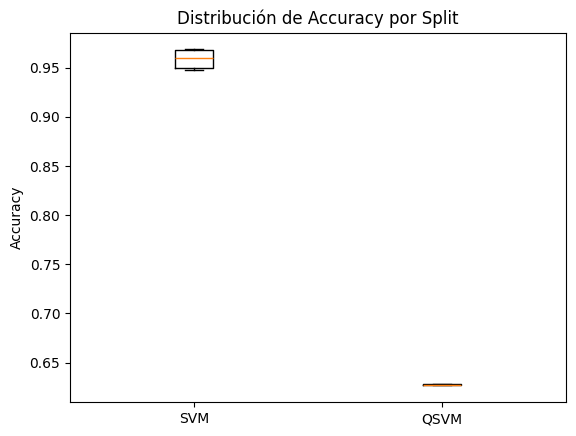

C:\Users\Cassandra\AppData\Local\Temp\ipykernel_5800\3774529347.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([f1_svm, f1_qsvm], labels=["SVM", "QSVM"])


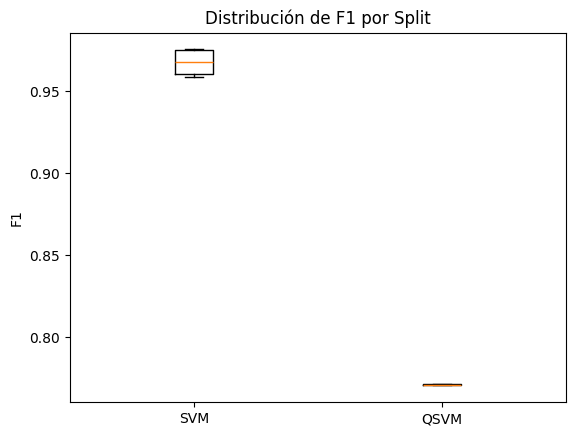

In [21]:
import matplotlib.pyplot as plt

# Boxplot accuracy
plt.figure()
plt.boxplot([acc_svm, acc_qsvm], labels=["SVM", "QSVM"])
plt.title("Distribución de Accuracy por Split")
plt.ylabel("Accuracy")
plt.show()

# Boxplot F1
plt.figure()
plt.boxplot([f1_svm, f1_qsvm], labels=["SVM", "QSVM"])
plt.title("Distribución de F1 por Split")
plt.ylabel("F1")
plt.show()


## 10) Resumen y exportación final
- CSV con métricas por *split*
- JSON con hiperparámetros óptimos por *split*
- Recordatorio sobre costos de *shots* si se usa hardware real


In [22]:
rows = []
for r in results:
    row = {
        "split": r["split"],
        "acc_svm": r["svm"]["acc"],
        "acc_qsvm": r["qsvm"]["acc"],
        "f1_svm": r["svm"]["f1"],
        "f1_qsvm": r["qsvm"]["f1"],
        "svm_best": json.dumps(r["svm"]["best_params"]),
        "qsvm_best": json.dumps(r["qsvm"]["best_params"]),
    }
    rows.append(row)

df = pd.DataFrame(rows)
csv_path = OUT_DIR / "per_split_metrics.csv"
df.to_csv(csv_path, index=False)
csv_path


WindowsPath('results_qsvm_experiment/per_split_metrics.csv')

---

### Apéndice A — Uso opcional de IBM Runtime (si tienes acceso)
Ejecutar en hardware real aumentará el **ruido** y demandará **más *shots*** para estimar el kernel con precisión.

> Requiere haber configurado `QiskitRuntimeService` con tu cuenta de IBM Quantum / IBM Cloud.


In [ ]:
# from qiskit_ibm_runtime import QiskitRuntimeService
# service = QiskitRuntimeService(channel="ibm_quantum", instance="ibm-q/open/main")
# backend = service.backend("ibm_sherbrooke")  # elige tu backend
# # Luego, crea FidelityQuantumKernel con Sampler/Estimator atado al backend si tu versión lo permite.
# # Consulta la doc de tu versión de Qiskit ML para vincular el Sampler al FidelityQuantumKernel.


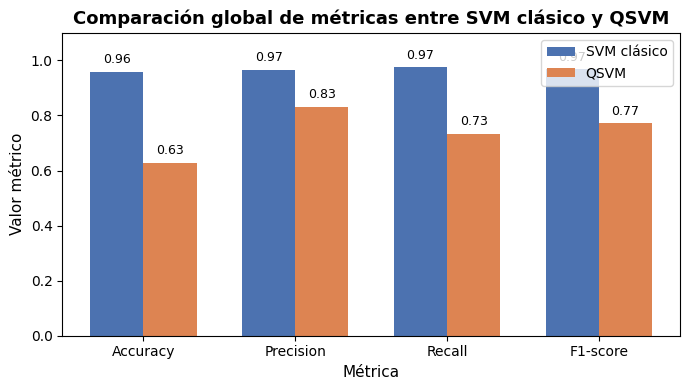

In [1]:
# ============================================
# COMPARACIÓN DE MÉTRICAS GLOBALES: SVM vs QSVM
# ============================================

import matplotlib.pyplot as plt
import numpy as np

# === 1. Datos de métricas globales ===
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']

svm_scores = [0.9587, 0.966, 0.975, 0.967]
qsvm_scores = [0.6274, 0.831, 0.734, 0.771]

x = np.arange(len(metrics))  # posiciones en el eje X
width = 0.35  # ancho de las barras

# === 2. Crear figura ===
fig, ax = plt.subplots(figsize=(7, 4))

# === 3. Barras ===
svm_bars = ax.bar(x - width/2, svm_scores, width, label='SVM clásico', color='#4C72B0')
qsvm_bars = ax.bar(x + width/2, qsvm_scores, width, label='QSVM', color='#DD8452')

# === 4. Etiquetas y formato ===
ax.set_ylim(0, 1.1)
ax.set_ylabel('Valor métrico', fontsize=11)
ax.set_xlabel('Métrica', fontsize=11)
ax.set_title('Comparación global de métricas entre SVM clásico y QSVM', fontsize=13, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# === 5. Mostrar valores encima de cada barra ===
for bars in [svm_bars, qsvm_bars]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}', 
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()
